# **Datasets Analysis :** Hopper

See the [gym documentation](https://www.gymlibrary.dev/environments/mujoco/hopper/) for more information on this environment.

**TYPES :**
- ***Expert*** : 1M samples from a policy trained to completion with SAC ;
- ***Medium-Expert*** : 50-50 split of medium and expert data (slightly less than 2M samples total) ;
- ***Medium*** : 1M samples from a policy trained to approximately 1/3 the performance of the expert ;
- ***Medium-Replay*** : Replay buffer of a policy trained up to the performance of the medium agent ;
- ***Random*** : 1M samples from a randomly initialized policy.

___
___

### **A. Environment**

<table>
<tr>
<tr>
<th style="padding: 25px;">Hopper<br><br><img src="../../../../assets/environments/gym_loco/hopper/hopper.gif" alt="Hopper" style="height: 200px;"/><br><br></th>
</tr>
</table>

___
___

### **B. Data**

In [32]:
import d4rl
import gym

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import torch

from offbench.data.episodes_db import GymLocoEpisodesDB
from typing import Dict, List

In [33]:
env = "hopper"

dataset_types = [
    "expert",
    "medium_expert",
    "medium",
    "medium_replay",
    "random"
]

dataset_type_to_db:Dict[str,GymLocoEpisodesDB] = {
    dataset_type: GymLocoEpisodesDB("-".join([env,dataset_type])) for dataset_type in dataset_types
}

load datafile:   0%|          | 0/21 [00:00<?, ?it/s]

load datafile: 100%|██████████| 9/9 [00:01<00:00,  7.93it/s]


___
___

### **C. Metrics**

#### C.1. Number of Episodes & Transitions

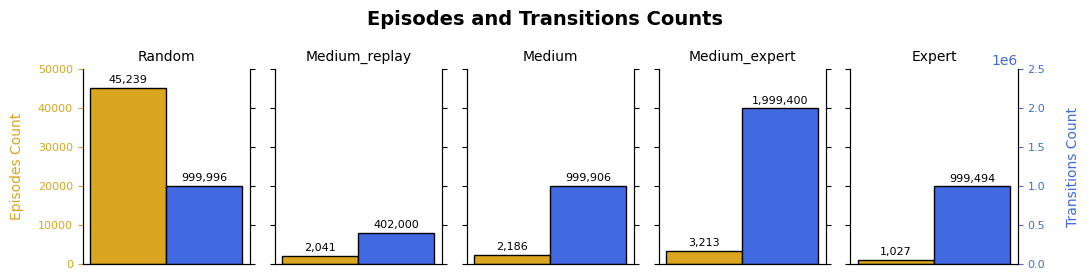

In [4]:
def compute_metrics(dataset_type_to_db: Dict[str,GymLocoEpisodesDB]) -> Dict[str, Dict[str, int]]:
    metrics = {}
    for dataset_type, db in dataset_type_to_db.items():
        num_episodes = len(db)
        num_transitions = sum(len(episode) for episode in db)
        metrics[dataset_type] = {"episodes": num_episodes, "transitions": num_transitions}
    return metrics

def plot_metrics_subplots(dataset_type_to_db: Dict[str,GymLocoEpisodesDB]) -> None:
    
    dataset_order = ["random", "medium_replay", "medium", "medium_expert", "expert"]

    # compute metrics
    metrics = compute_metrics(dataset_type_to_db)

    # extract data in the defined order
    num_episodes = [metrics[dataset_type]["episodes"] for dataset_type in dataset_order]
    num_transitions = [metrics[dataset_type]["transitions"] for dataset_type in dataset_order]

    # create subplots
    fig, axes = plt.subplots(1, len(dataset_order), figsize=(11, 2.5), sharey=False)

    max_episodes = max(num_episodes)
    max_transitions = max(num_transitions)

    for i, dataset_type in enumerate(dataset_order):

        ax = axes[i]
        ax2 = ax.twinx()  # Create secondary y-axis for transitions

        # plot number of episodes on the left y-axis
        ax.bar([0], [num_episodes[i]], width=0.4, color="goldenrod", edgecolor="black", align="center", label="Episodes")
        ax.set_yticks([0,10000,20000,30000,40000,50000])
        
        # plot number of transitions on the right y-axis
        ax2.bar([0.4], [num_transitions[i]], width=0.4, color="royalblue", edgecolor="black", align="center", label="Transitions")
        ax2.set_yticks([0.0,0.5e6,1.0e6,1.5e6,2.0e6,2.5e6])

        # add value annotations for bars
        ax.text(0, num_episodes[i] + max_episodes * 0.03, f"{num_episodes[i]:,}", ha="center", fontsize=8)
        ax2.text(0.4, num_transitions[i] + max_transitions * 0.03, f"{num_transitions[i]:,}", ha="center", fontsize=8)
        
        # add dataset title
        ax.set_title(dataset_type.capitalize(), fontsize=10)
        ax.set_xticks([])
        ax.tick_params(axis="both", which="major", labelsize=8)

        # remove top frame line, show right frame for secondary y-axis
        ax.spines['top'].set_visible(False)
        ax2.spines['top'].set_visible(False)
        ax2.tick_params(labelsize=8)

        # show y-tick labels for episodes only on the first subplot
        if i == 0:
            ax.set_ylabel("Episodes Count", fontsize=10, color="goldenrod")
            ax.tick_params(axis="y", labelcolor="goldenrod", colors="goldenrod")
            ax.yaxis.labelpad = 10
        else:
            ax.tick_params(axis="y", labelleft=False)

        # show y-tick labels for transitions only on the last subplot
        if i == len(dataset_order) - 1:
            ax2.set_ylabel("Transitions Count", fontsize=10, color="royalblue")
            ax2.tick_params(axis="y", labelcolor="royalblue", colors="royalblue")
            ax2.yaxis.labelpad = 15
        else:
            ax2.tick_params(axis="y", labelright=False)

    # add overall title
    plt.tight_layout()
    plt.suptitle("Episodes and Transitions Counts", y=1.1, fontsize=14, fontweight="bold")

    # save plot
    plt.savefig("./plots/episodes_transitions_counts.png",transparent=False)
    plt.savefig("./plots/episodes_transitions_counts_transparent.png",transparent=True)

    # show plot
    plt.show()

plot_metrics_subplots(dataset_type_to_db)

#### C.2. Episodes Length

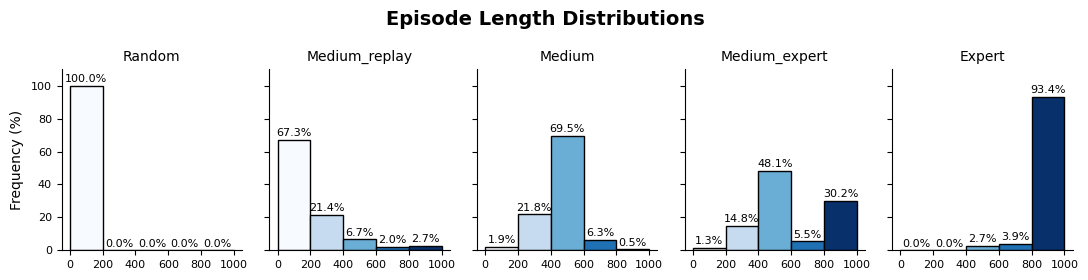

In [5]:
def compute_episode_lengths(episodes_db:GymLocoEpisodesDB) -> List[int]:
    lengths = [len(episode) for episode in episodes_db]
    return lengths

def plot_episode_lengths(dataset_type_to_db:Dict[str,GymLocoEpisodesDB]) -> None:

    dataset_order = ["random", "medium_replay", "medium", "medium_expert", "expert"]

    fig, axes = plt.subplots(1, len(dataset_order), figsize=(11,2.5), sharey=True)

    for i, dataset_type in enumerate(dataset_order):
        
        db = dataset_type_to_db[dataset_type]
        lengths = compute_episode_lengths(db)
        
        # define custom bins
        bins = [0, 200, 400, 600, 800, 1000]
        
        # compute the histogram data as percentages
        counts, bins = np.histogram(lengths, bins=bins)
        percentages = (counts / counts.sum()) * 100
        bin_centers = (bins[:-1] + bins[1:]) / 2
        
        # generate colors from a colormap
        cmap = cm.Blues 
        colors = [cmap(i / (len(bin_centers) - 1)) for i in range(len(bin_centers))]
        
        # plot as a bar chart for percentages
        bars = axes[i].bar(bin_centers, percentages, width=(bins[1] - bins[0]), align="center", color=colors, edgecolor="black")
        axes[i].set_title(f"{dataset_type.capitalize()}", fontsize=10)
        axes[i].set_xticks(bins)
        axes[i].tick_params(axis="both", which="major", labelsize=8)
        axes[i].set_ylim(0, 110)
        if i == 0:
            axes[i].set_ylabel("Frequency (%)", fontsize=10)
        axes[i].yaxis.labelpad = 5    

        # remove right and top lines of the frames
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['top'].set_visible(False)

        # add value labels above bars
        for bar, percentage in zip(bars, percentages):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width()/2., height + 1, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=8)

    # adjust spacing between subplots
    plt.tight_layout()
    plt.suptitle("Episode Length Distributions", y=1.1, fontsize=14, fontweight="bold")

    # save plot
    plt.savefig("./plots/length_distributions.png",transparent=False)
    plt.savefig("./plots/length_distributions_transparent.png",transparent=True)

    # show plot
    plt.show()

plot_episode_lengths(dataset_type_to_db)

### C.3. Episodes Reward

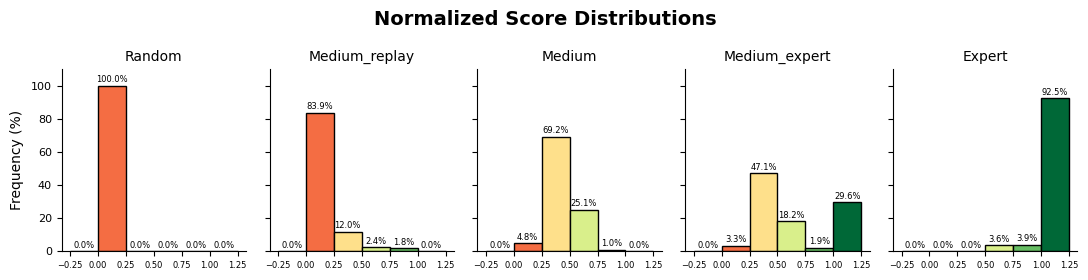

In [6]:
def compute_episode_rewards(dataset_type, episodes_db:GymLocoEpisodesDB) -> List[float]:
    dataset_type = "-".join(dataset_type.split("_"))
    gym_env = gym.make(f"{env}-{dataset_type}-v2")
    rewards = []
    for episode_id in episodes_db.get_ids():
        episode = episodes_db[episode_id].to_dict()
        rewards.append(gym_env.get_normalized_score(episode["reward"].sum()))
    return rewards

def plot_reward_distributions(dataset_type_to_db:Dict[str,GymLocoEpisodesDB]) -> None:
    
    dataset_order = ["random", "medium_replay", "medium", "medium_expert", "expert"]
    bin_edges = [-0.25, 0.0, 0.25, 0.5, 0.75, 1.0, 1.25]

    fig, axes = plt.subplots(1, len(dataset_order), figsize=(11, 2.5), sharey=True)

    for i, dataset_type in enumerate(dataset_order):
        
        db = dataset_type_to_db[dataset_type]
        rewards = compute_episode_rewards(dataset_type, db)

        # compute histogram data based on predefined bins
        counts, _ = np.histogram(rewards, bins=bin_edges)
        percentages = (counts / counts.sum()) * 100
        bin_centers = (np.array(bin_edges[:-1]) + np.array(bin_edges[1:])) / 2

        # generate colors from blue to yellow using a colormap
        cmap = cm.RdYlGn
        colors = [cmap(i / (len(bin_centers) - 1)) for i in range(len(bin_centers))]

        # plot as a bar chart for percentages
        bars = axes[i].bar(bin_centers, percentages, width=(bin_edges[1] - bin_edges[0]), align="center", color=colors, edgecolor="black")
        axes[i].set_title(f"{dataset_type.capitalize()}", fontsize=10)
        axes[i].set_xticks(bin_edges)
        axes[i].tick_params(axis="both", which="major", labelsize=8)
        axes[i].tick_params(axis="x", labelsize=6)
        axes[i].set_ylim(0, 110)
        if i == 0:
            axes[i].set_ylabel("Frequency (%)", fontsize=10)
        axes[i].yaxis.labelpad = 5

        # remove right and top lines of the frames
        axes[i].spines['right'].set_visible(False)
        axes[i].spines['top'].set_visible(False)

        # add value labels above bars
        for bar, percentage in zip(bars, percentages):
            height = bar.get_height()
            axes[i].text(bar.get_x() + bar.get_width() / 2., height + 1, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=6)

    # adjust spacing between subplots
    plt.tight_layout()
    plt.suptitle("Normalized Score Distributions", y=1.1, fontsize=14, fontweight="bold")

    # save plot
    plt.savefig("./plots/reward_distributions.png",transparent=False)
    plt.savefig("./plots/reward_distributions_transparent.png",transparent=True)

    # show plot
    plt.show()

plot_reward_distributions(dataset_type_to_db)

___
___